[0]	validation_0-rmse:634427.97512	validation_1-rmse:872005.95446
[100]	validation_0-rmse:337906.93493	validation_1-rmse:509081.25351
[200]	validation_0-rmse:234102.60347	validation_1-rmse:390367.55823
[300]	validation_0-rmse:195424.50541	validation_1-rmse:348386.26859
[400]	validation_0-rmse:179606.18985	validation_1-rmse:332029.05510
[500]	validation_0-rmse:171248.48855	validation_1-rmse:327268.46561
[600]	validation_0-rmse:165602.90800	validation_1-rmse:326309.83921
[693]	validation_0-rmse:161838.90848	validation_1-rmse:326736.60822
R^2: 0.8085
MAE: 255495.41 MWh/día


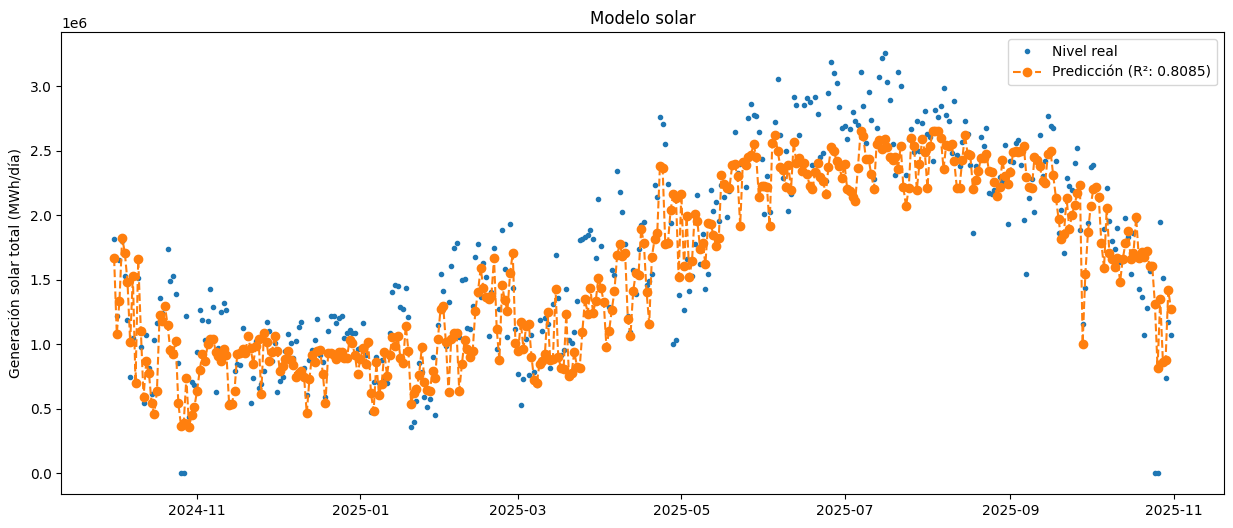

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

df_5min['sol_total'] = df_5min['solFot'] + df_5min['solTer']

agg_dict = {
    'sol_total': 'sum',
    
    'precipitacion_nacional_ponderada': 'first',
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
}

df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'sol_total': 'sol_total_dia'})

df_1d['sol_total_lag_7d'] = df_1d['sol_total_dia'].shift(7)
df_1d['sol_total_lag_14d'] = df_1d['sol_total_dia'].shift(14)
df_1d['sol_total_mean_28d'] = df_1d['sol_total_dia'].shift(7).rolling(window=28).mean()
df_1d['sol_total_std_28d'] = df_1d['sol_total_dia'].shift(7).rolling(window=28).std()
df_1d['sol_total_lag_364d'] = df_1d['sol_total_dia'].shift(364)

df_1d = df_1d.dropna() 

TARGET_NIVEL = 'sol_total_dia'
FEATURES_NIVEL = [
    'dia_año_sin',
    'dia_año_cos',
    'precipitacion_nacional_ponderada',
    'sol_total_lag_7d',
    'sol_total_lag_14d',
    'sol_total_mean_28d',
    'sol_total_std_28d',
    'sol_total_lag_364d'
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]

X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_solar = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_solar.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=100)

MODEL_PATH = '../models/modelo_sol.json'
model_nivel_solar.save_model(MODEL_PATH)

preds_nivel = model_nivel_solar.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.', linestyle='None')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo solar')
plt.ylabel('Generación solar total (MWh/día)')
plt.legend()
plt.show()